In [1]:
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from tqdm import tqdm

# =====================================================
# Configuration
# =====================================================
data_dir = "/data/projects/nckf/frekle/EOF_results/EC-Earth3"
varname = "so"
fixed_ref_member = "r1i1p1f1"  # fixed reference

# Figure save directories
save_dir_eof = "/data/users/frekle/EOF/EC-Earth3/Figures/so"
save_dir_aligned = os.path.join(save_dir_eof, "Aligned")
os.makedirs(save_dir_eof, exist_ok=True)
os.makedirs(save_dir_aligned, exist_ok=True)

# =====================================================
# Helper functions
# =====================================================
def pattern_corr(eof1, eof2):
    a, b = eof1.values.flatten(), eof2.values.flatten()
    mask = np.isfinite(a) & np.isfinite(b)
    a, b = a[mask], b[mask]
    if len(a) < 3:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

def enforce_positive_corr(pc_mean_ref, global_ref_pc):
    corr = np.corrcoef(pc_mean_ref, global_ref_pc)[0, 1]
    return -pc_mean_ref if corr < 0 else pc_mean_ref

# =====================================================
# Load EOF datasets
# =====================================================
files = sorted(glob.glob(os.path.join(data_dir, f"EOF_{varname}_r*.nc")))
members = [os.path.basename(f).split("_")[-1].replace(".nc", "") for f in files]
print(f"Found {len(files)} EOF files for {varname}")

eofs_dict, pcs_dict, varfrac_dict = {}, {}, {}
for f in files:
    member = os.path.basename(f).split("_")[-1].replace(".nc", "")
    ds = xr.open_dataset(f)
    eofs_dict[member] = ds["EOFs"]
    pcs_dict[member] = ds["PCs"]
    varfrac_dict[member] = ds["variance_fraction"]

n_modes = eofs_dict[members[0]].sizes["mode"]

# =====================================================
# Plot EOFs (1–3)
# =====================================================
ref_member = fixed_ref_member
ref_eofs = eofs_dict[ref_member]
ref_varfrac = varfrac_dict[ref_member]

fig, axes = plt.subplots(1, 3, figsize=(15, 4),
                         subplot_kw={'projection': ccrs.Robinson()})
for i in range(3):
    ax = axes[i]
    eof = ref_eofs.isel(mode=i)
    im = ax.pcolormesh(eof.lon, eof.lat, eof, cmap="RdBu_r", transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f"EOF{i+1} ({ref_varfrac.isel(mode=i).values*100:.1f}%)", fontsize=11)
    plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05)
fig.suptitle(f"First 3 EOFs of SSS ({ref_member})", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(os.path.join(save_dir_eof, f"EOF_{varname}_EOFs_{ref_member}.png"), dpi=300)
plt.close()

# =====================================================
# Plot PCs (1–3)
# =====================================================
ref_pcs = pcs_dict[ref_member]
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot(ref_pcs["time"], ref_pcs[:, i], color="navy", lw=1.5)
    ax.set_ylabel(f"PC{i+1}")
    ax.grid(alpha=0.3)
axes[-1].xaxis.set_major_locator(mdates.YearLocator(20))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axes[-1].set_xlabel("Year")
fig.suptitle(f"First 3 PCs of SSS ({ref_member})", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(os.path.join(save_dir_eof, f"EOF_{varname}_PCs_{ref_member}.png"), dpi=300)
plt.close()

# =====================================================
# Plot explained variance
# =====================================================
mean_varfrac = xr.concat(list(varfrac_dict.values()), dim="member").mean(dim="member")
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, n_modes+1), mean_varfrac*100, color="teal", alpha=0.7)
ax.set_xlabel("EOF mode")
ax.set_ylabel("Explained variance (%)")
ax.set_title(f"Mean explained variance across ensemble ({varname})")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(save_dir_eof, f"EOF_{varname}_variance_fraction.png"), dpi=300)
plt.close()

# =====================================================
# Alignment diagnostics (1–3)
# =====================================================
pc_means_all = []
for mode in [0, 1, 2]:
    print(f"\nAligning PC{mode+1} for all reference choices...")
    global_ref_pc = pcs_dict[fixed_ref_member][:, mode]
    pc_means = []

    for i_ref, ref_member in enumerate(tqdm(members, desc=f"Mode {mode+1}")):
        ref_eofs = eofs_dict[ref_member]
        aligned_pcs = []

        for target_member in members:
            eofs = eofs_dict[target_member]
            pcs = pcs_dict[target_member]

            corr_matrix = np.zeros((n_modes, n_modes))
            for i in range(n_modes):
                for j in range(n_modes):
                    corr_matrix[i, j] = pattern_corr(ref_eofs.isel(mode=i), eofs.isel(mode=j))
            
            best_match = np.argmax(np.abs(corr_matrix), axis=0)
            reordered_pcs = pcs[:, best_match]

            for m in range(n_modes):
                if corr_matrix[m, best_match[m]] < 0:
                    reordered_pcs[:, m] *= -1

            aligned_pcs.append(reordered_pcs[:, mode])

        aligned_pcs = xr.concat(aligned_pcs, dim="member")
        aligned_pcs["member"] = members
        pc_mean_ref = aligned_pcs.mean(dim="member")

        pc_mean_ref = enforce_positive_corr(pc_mean_ref, global_ref_pc)
        pc_means.append(pc_mean_ref)

    pc_means = xr.concat(pc_means, dim="ref")
    pc_means["ref"] = members
    pc_means_all.append(pc_means)

# =====================================================
# Plot alignment results
# =====================================================
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for mode, ax in enumerate(axes):
    pc_means = pc_means_all[mode]
    pc_mean_global = pc_means.mean(dim="ref")
    pc_std_global = pc_means.std(dim="ref")

    for i in range(pc_means.sizes["ref"]):
        ax.plot(pc_means["time"], pc_means.isel(ref=i), color="gray", alpha=0.5, lw=1)

    ax.plot(pc_mean_global["time"], pc_mean_global, color="crimson", lw=2, label=f"Mean PC{mode+1}")
    ax.fill_between(
        pc_mean_global["time"].values,
        (pc_mean_global - pc_std_global).values,
        (pc_mean_global + pc_std_global).values,
        color="crimson", alpha=0.3,
    )

    ax.set_ylabel(f"PC{mode+1} amplitude (aligned, ref={fixed_ref_member})")
    ax.legend()
    ax.grid(alpha=0.3)

    ax.xaxis.set_major_locator(mdates.YearLocator(20))
    ax.xaxis.set_minor_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45)

axes[-1].set_xlabel("Year")
fig.suptitle(
    f"SSS alignment stability: Mean PCs (1–3) for all reference choices\n(signs oriented to {fixed_ref_member})",
    fontsize=14,
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(save_dir_aligned, f"EOF_{varname}_alignment_stability.png"), dpi=300)
plt.close()

print(f"\n✅ Saved all EOF and alignment plots for {varname} to:")
print(f"   • {save_dir_eof}")
print(f"   • {save_dir_aligned}")


Found 22 EOF files for so

Aligning PC1 for all reference choices...


Mode 1: 100%|██████████| 22/22 [00:56<00:00,  2.55s/it]



Aligning PC2 for all reference choices...


Mode 2: 100%|██████████| 22/22 [00:56<00:00,  2.59s/it]



Aligning PC3 for all reference choices...


Mode 3: 100%|██████████| 22/22 [00:55<00:00,  2.50s/it]



✅ Saved all EOF and alignment plots for so to:
   • /data/users/frekle/EOF/EC-Earth3/Figures/so
   • /data/users/frekle/EOF/EC-Earth3/Figures/so/Aligned


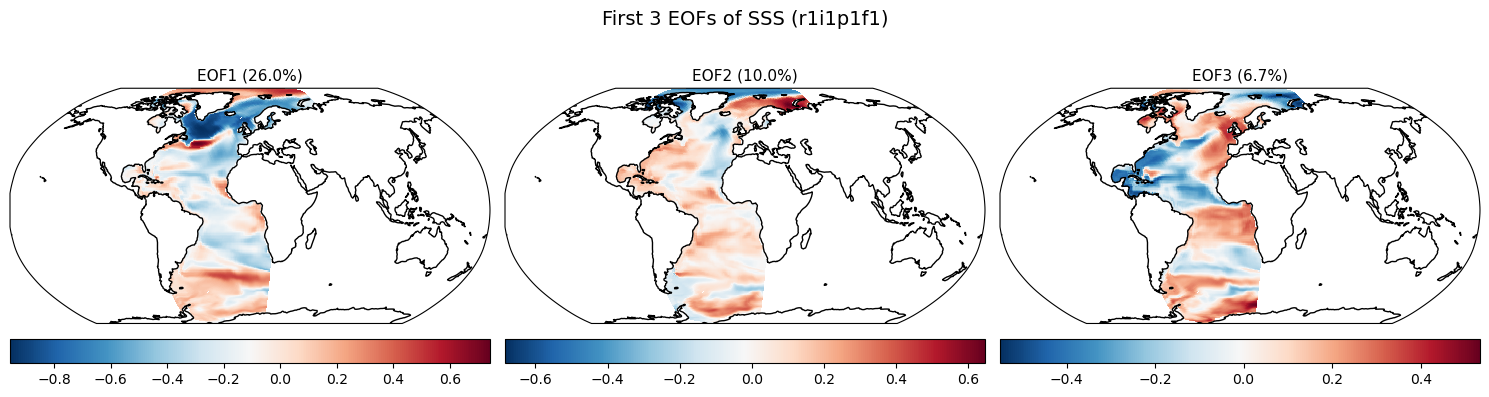

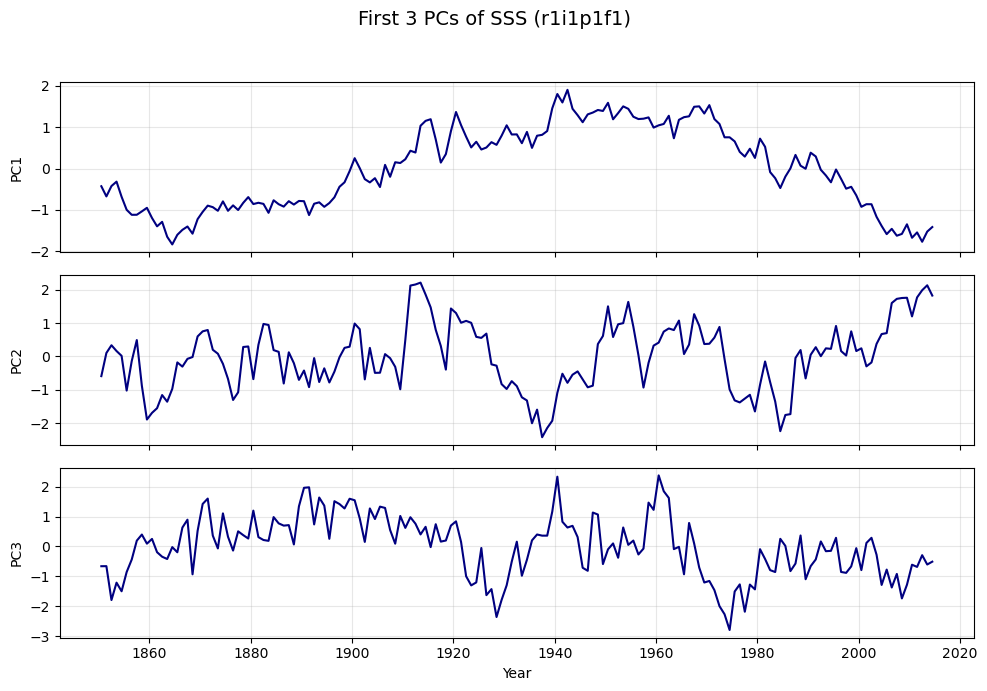

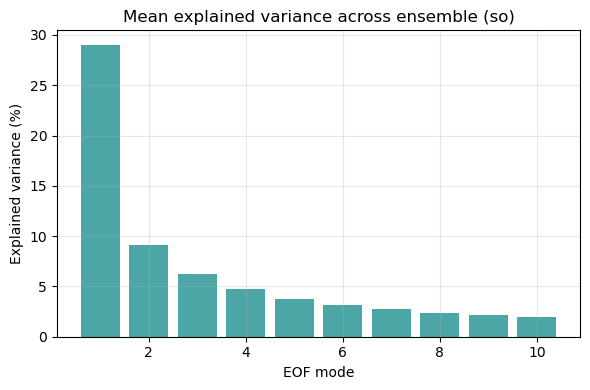

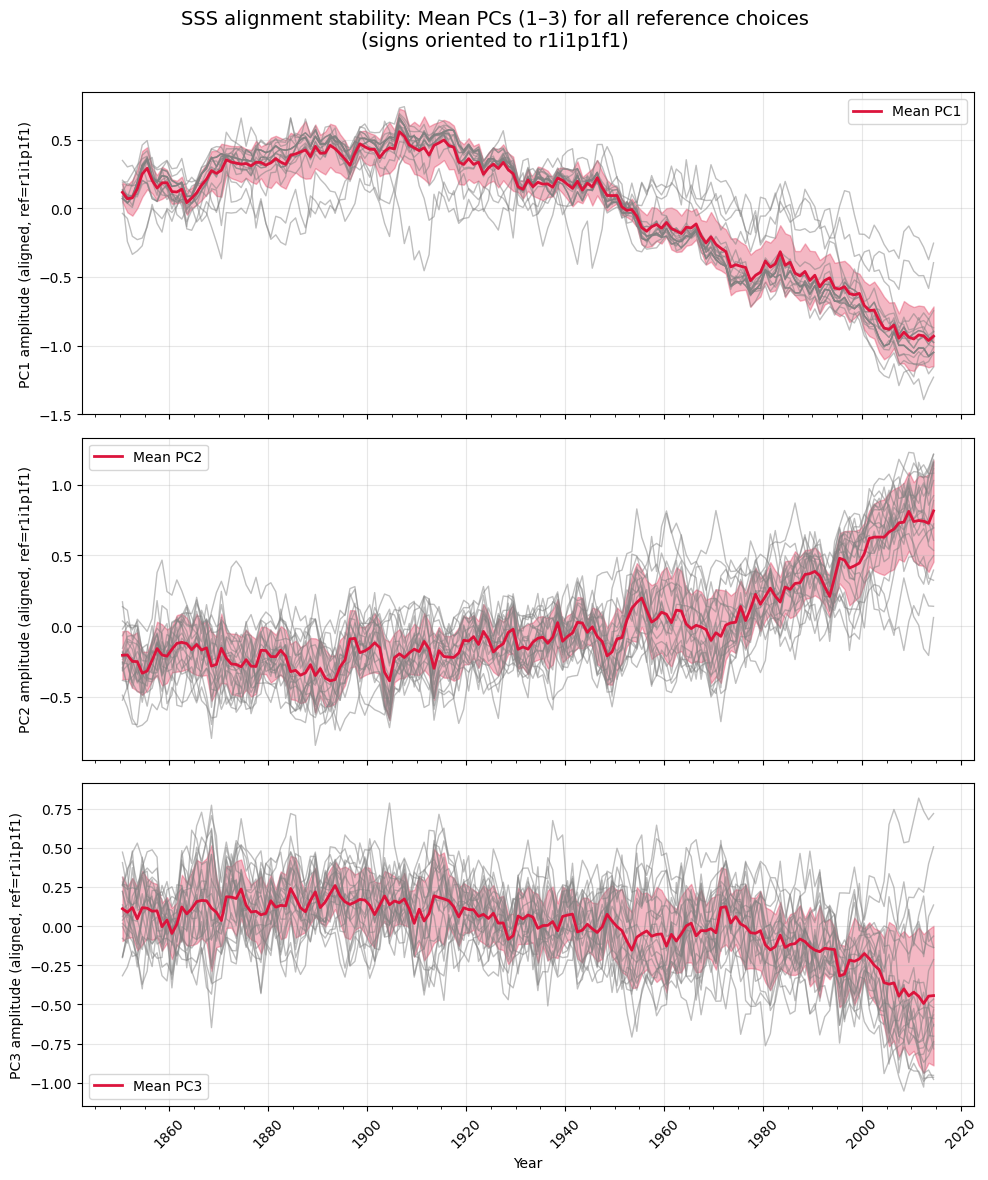

In [2]:
# =====================================================
# Plot EOFs (1–3)
# =====================================================
ref_member = fixed_ref_member
ref_eofs = eofs_dict[ref_member]
ref_varfrac = varfrac_dict[ref_member]

fig, axes = plt.subplots(1, 3, figsize=(15, 4),
                         subplot_kw={'projection': ccrs.Robinson()})
for i in range(3):
    ax = axes[i]
    eof = ref_eofs.isel(mode=i)
    im = ax.pcolormesh(eof.lon, eof.lat, eof, cmap="RdBu_r", transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f"EOF{i+1} ({ref_varfrac.isel(mode=i).values*100:.1f}%)", fontsize=11)
    plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05)
fig.suptitle(f"First 3 EOFs of SSS ({ref_member})", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# =====================================================
# Plot PCs (1–3)
# =====================================================
ref_pcs = pcs_dict[ref_member]
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot(ref_pcs["time"], ref_pcs[:, i], color="navy", lw=1.5)
    ax.set_ylabel(f"PC{i+1}")
    ax.grid(alpha=0.3)
axes[-1].xaxis.set_major_locator(mdates.YearLocator(20))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axes[-1].set_xlabel("Year")
fig.suptitle(f"First 3 PCs of SSS ({ref_member})", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# =====================================================
# Plot explained variance
# =====================================================
mean_varfrac = xr.concat(list(varfrac_dict.values()), dim="member").mean(dim="member")
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, n_modes+1), mean_varfrac*100, color="teal", alpha=0.7)
ax.set_xlabel("EOF mode")
ax.set_ylabel("Explained variance (%)")
ax.set_title(f"Mean explained variance across ensemble ({varname})")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot alignment results
# =====================================================
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for mode, ax in enumerate(axes):
    pc_means = pc_means_all[mode]
    pc_mean_global = pc_means.mean(dim="ref")
    pc_std_global = pc_means.std(dim="ref")

    for i in range(pc_means.sizes["ref"]):
        ax.plot(pc_means["time"], pc_means.isel(ref=i), color="gray", alpha=0.5, lw=1)

    ax.plot(pc_mean_global["time"], pc_mean_global, color="crimson", lw=2, label=f"Mean PC{mode+1}")
    ax.fill_between(
        pc_mean_global["time"].values,
        (pc_mean_global - pc_std_global).values,
        (pc_mean_global + pc_std_global).values,
        color="crimson", alpha=0.3,
    )

    ax.set_ylabel(f"PC{mode+1} amplitude (aligned, ref={fixed_ref_member})")
    ax.legend()
    ax.grid(alpha=0.3)

    ax.xaxis.set_major_locator(mdates.YearLocator(20))
    ax.xaxis.set_minor_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45)

axes[-1].set_xlabel("Year")
fig.suptitle(
    f"SSS alignment stability: Mean PCs (1–3) for all reference choices\n(signs oriented to {fixed_ref_member})",
    fontsize=14,
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()